In [1]:
# Import libraries

import pandas as pd
import numpy as np
import sqlite3
import datetime
import sys
import plotly.express as px
import plotly.graph_objects as px_o
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# load the datasets

df_orders = pd.read_csv('orders.csv')
df_customers = pd.read_csv('customers.csv')
df_line_items = pd.read_csv('line_items.csv')

### Missing values

In [3]:
# Check to see is I have missing values
df_customers.isnull().sum()

customer_uid           0
is_business            0
has_account            0
bill_state             6
acquisition_channel    0
dtype: int64

I thought I would be able to use ship_state (column in orders table) for missing bill_states but they are 100s of cases that these two variables are different. So, I decided to categorize the missing bill_states as "unknown".

In [4]:
df_customers['bill_state'].unique()

array(['OK', 'CA', 'WA', 'TX', 'IL', 'NY', 'NC', 'VA', 'FL', 'SC', 'OH',
       'MD', 'PA', 'IN', 'NJ', 'TN', 'MO', 'VT', 'IA', 'MI', 'GA', 'MS',
       'MA', 'CT', 'KY', 'WI', 'SD', 'AR', 'MN', 'LA', 'NH', 'NE', 'AL',
       'ND', 'RI', 'KS', 'AZ', 'OR', 'CO', 'UT', 'NM', 'WY', 'MT', 'NV',
       'WV', 'AK', 'ME', 'ID', 'ON', 'DE', nan, 'DC', 'HI', 'BC', 'AE'],
      dtype=object)

In [5]:
df_customers['bill_state'] = df_customers['bill_state'].fillna('Unknown')

### Feature engineering

There is a lot of information that could be gained from line_items and orders tables about shopping attitude of the customers.
I added three features using line_items and orders to the customers table, but one could build more features if there were more time.

#### Adding quantity feature

This feature is supposed to say what is the total quantity of items purchased by each customer.

In [6]:
df_customers.shape

(10000, 5)

In [7]:
len(df_orders.customer_uid.unique())

8457

The number of customers are larger in customers table. This means that some customers have never purchased anything. I will take care of these cases later in the analysis.

In [8]:
# adding quantity feature for each order to orders table
df_quantities = df_line_items.groupby('order_id').agg({'quantity': np.sum}).reset_index()
df_temp = pd.merge(df_orders, df_quantities, on='order_id', how='left').reset_index()

print('Do I have a row that there is an order but the quantity is NULL?')
df_temp[df_temp['quantity'].isnull()]

Do I have a row that there is an order but the quantity is NULL?


,index,order_id,customer_uid,order_timestamp,discount,ship_state,shipping_revenue,shipping_cost,returned,quantity
18474,18474,23676037,eae8a7565d0198b84f2277378407cb6f,2019-10-12 22:04:47.786,0.0,FL,0.0,8.54,False,NaN


I will remove this order because when there's no quantity, there is not enough information about this order.

In [9]:
df_temp = df_temp.drop(df_temp.loc[~(df_temp['order_id'].isnull())
        &(df_temp['quantity'].isnull())].index)

Add the quantity to customers table:

In [10]:
df_orders = df_temp
df_temp = pd.merge(df_customers, df_orders, on='customer_uid', how='left')

Cases that customers have never placed an order:

In [11]:
df_temp.loc[(df_temp['order_id'].isnull())].head()

,customer_uid,is_business,has_account,bill_state,acquisition_channel,index,order_id,order_timestamp,discount,ship_state,shipping_revenue,shipping_cost,returned,quantity
55,74ae1c5c093c9e6f3227eec1aff5378d,False,False,GA,organic search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,eb76b0298d57542bdfe2043835f32d3a,False,False,IL,organic search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,f9c578d17da31a9b611193edaa00e6af,False,True,TX,direct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,924a299002ae424ffdccfb943889f91c,False,False,CA,organic search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,e052c9437e77aaf1725f8632e85b8c3e,False,False,GA,direct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# the customers who never ordered the quantity for them is 0
df_temp['quantity'] = df_temp['quantity'].fillna(0)
# adding quantity column to customers table
df_temp = df_temp.groupby('customer_uid').agg({'quantity': np.sum}).reset_index()
df_customers = pd.merge(df_customers, df_temp, on='customer_uid', how='left')

In [13]:
df_customers.head()

,customer_uid,is_business,has_account,bill_state,acquisition_channel,quantity
0,7d30104b82c22393003ac3c07b491c15,False,False,OK,coupon aggregator,15.0
1,77a48e4c4a69458d3421c54058350f93,False,False,CA,organic search,6.0
2,c9fe0dadc9e25ab478144bbd3a0ae750,False,False,WA,organic search,3.0
3,7a8bdb597d753c6c7430ea4e1d52fc48,False,False,TX,organic search,1.0
4,becb1413c375caba8707085efaac08e9,False,False,IL,organic search,7.0


#### Adding recent feature

This feature represents how recent customers have purchased their latest order.

In [14]:
# convert order_timestamp to date
# add date column to customer table
df_orders['date'] = pd.to_datetime(df_orders['order_timestamp']).dt.date
# get the date of the last order for each customer
df_temp = df_orders.groupby('customer_uid').agg({'date': max}).reset_index()
df_temp = pd.merge(df_customers, df_temp, on='customer_uid', how='left')

# calculate recent variable that is (the max date in the dataset - the date of the last order of each customer)
max_date = max(df_temp['date'][~df_temp['date'].isnull()])
df_temp['recent'] = (max_date - df_temp['date']).dt.days
# I assign large number to recent variable for customers that have never placed an order
df_temp.loc[df_temp['date'].isnull(), 'recent'] = 10000
# drop the date column I made because I don't need it anymore
df_temp.drop('date', axis=1, inplace=True)
df_customers = df_temp

df_customers.head()

,customer_uid,is_business,has_account,bill_state,acquisition_channel,quantity,recent
0,7d30104b82c22393003ac3c07b491c15,False,False,OK,coupon aggregator,15.0,1822.0
1,77a48e4c4a69458d3421c54058350f93,False,False,CA,organic search,6.0,525.0
2,c9fe0dadc9e25ab478144bbd3a0ae750,False,False,WA,organic search,3.0,517.0
3,7a8bdb597d753c6c7430ea4e1d52fc48,False,False,TX,organic search,1.0,781.0
4,becb1413c375caba8707085efaac08e9,False,False,IL,organic search,7.0,1323.0


#### Adding frequency feature

This feature represents how many times customers have purchased.

In [15]:
# make the frequency feature in orders table
df_temp = df_orders.groupby('customer_uid')['date'].size().reset_index()
df_temp.rename(columns={'date': 'frequency'}, inplace=True)

# add the frequency to customers table
df_temp = pd.merge(df_customers, df_temp, on='customer_uid', how='left')
# customers that have never ordered frequency should be 0
df_temp['frequency'].fillna(0, inplace=True)
df_customers = df_temp
df_customers.head()

,customer_uid,is_business,has_account,bill_state,acquisition_channel,quantity,recent,frequency
0,7d30104b82c22393003ac3c07b491c15,False,False,OK,coupon aggregator,15.0,1822.0,1.0
1,77a48e4c4a69458d3421c54058350f93,False,False,CA,organic search,6.0,525.0,1.0
2,c9fe0dadc9e25ab478144bbd3a0ae750,False,False,WA,organic search,3.0,517.0,1.0
3,7a8bdb597d753c6c7430ea4e1d52fc48,False,False,TX,organic search,1.0,781.0,1.0
4,becb1413c375caba8707085efaac08e9,False,False,IL,organic search,7.0,1323.0,1.0


In [16]:
# quantity, recent and frequency should be integer
df_customers['quantity'] = df_customers['quantity'].apply(int)
df_customers['recent'] = df_customers['recent'].apply(int)
df_customers['frequency'] = df_customers['frequency'].apply(int)

In [17]:
df_customers.head()

,customer_uid,is_business,has_account,bill_state,acquisition_channel,quantity,recent,frequency
0,7d30104b82c22393003ac3c07b491c15,False,False,OK,coupon aggregator,15,1822,1
1,77a48e4c4a69458d3421c54058350f93,False,False,CA,organic search,6,525,1
2,c9fe0dadc9e25ab478144bbd3a0ae750,False,False,WA,organic search,3,517,1
3,7a8bdb597d753c6c7430ea4e1d52fc48,False,False,TX,organic search,1,781,1
4,becb1413c375caba8707085efaac08e9,False,False,IL,organic search,7,1323,1


In [18]:
# keep the roginal table because I am going to do one scaling, normalization and hot encoding
df_customers_original = df_customers.copy()

### EDA

#### Plotting functions

In [19]:
def plot_hist(df, col):
    
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,4))
    col_count = 0
    for i in range(1):
        for j in range(3):
            axes[j].hist(df[col[col_count]])
            axes[j].set_xlabel(col[col_count])
            col_count += 1

    plt.tight_layout()    
    plt.show()
    
    
def plot_boxplot(df, col):
    
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,4))
    col_count = 0
    for i in range(1):
        for j in range(3):
            axes[j].boxplot(df[col[col_count]])
            axes[j].set_xlabel(col[col_count])
            col_count += 1

    plt.tight_layout()    
    plt.show()
    
def plot_bars(df, col):
    df = pd.DataFrame({col: df[col].unique(), 'count': df[col].value_counts()})
    fig = px.bar(df, x=col, y = 'count', title=col)
    fig.update_xaxes(type='category')
    fig.show()

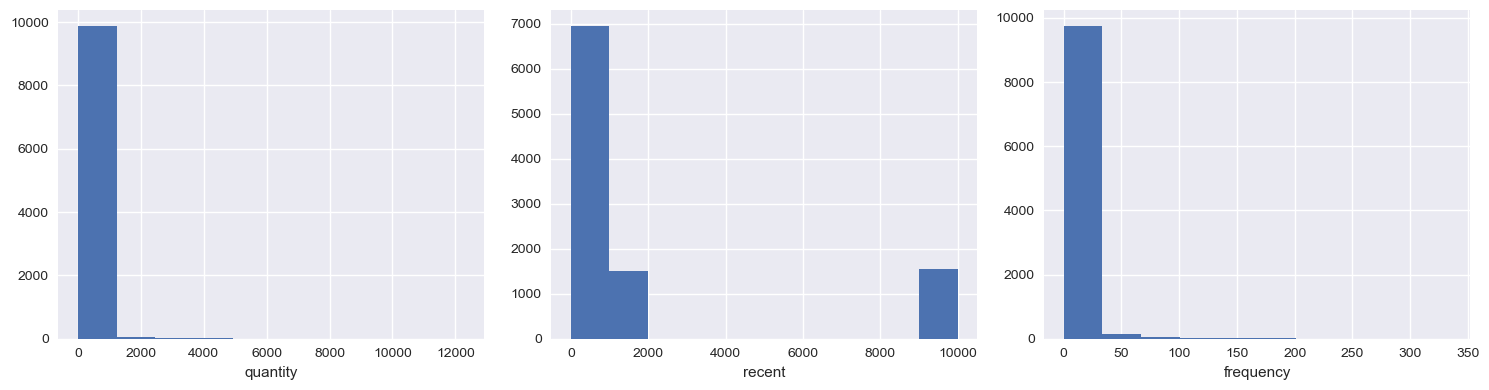

In [20]:
# histogram of numerical features
col = ['quantity', 'recent','frequency']
plot_hist(df_customers, col)

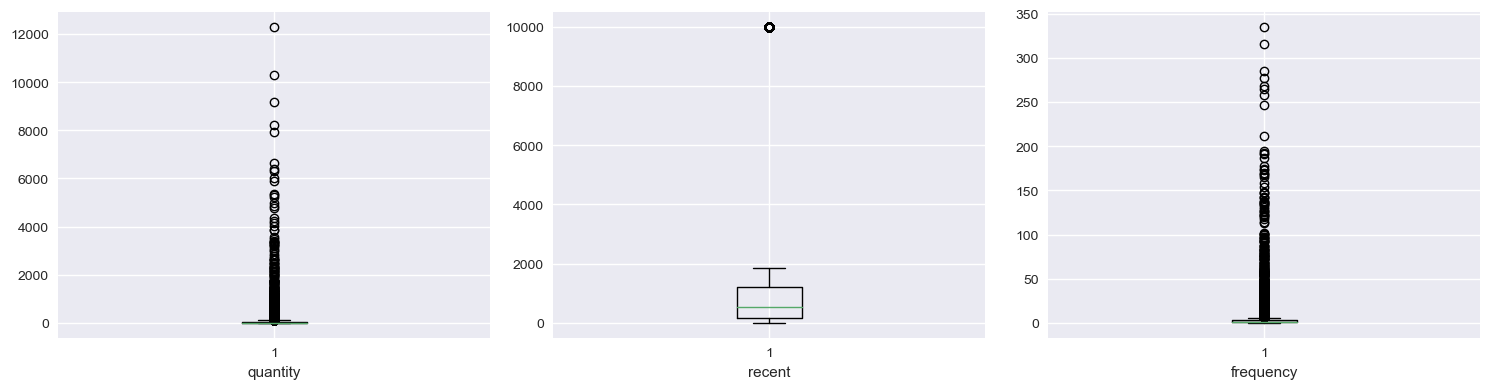

In [21]:
# barplots of numerical features
plot_boxplot(df_customers, col)

It shows how skewed my data is! For that I use log transfomation to normalize my data.

#### Normalization

In [22]:
# Normalizing the numerical columns
for c in col:
    df_customers[c] = np.log(df_customers[c].values.reshape(-1, 1)+1)

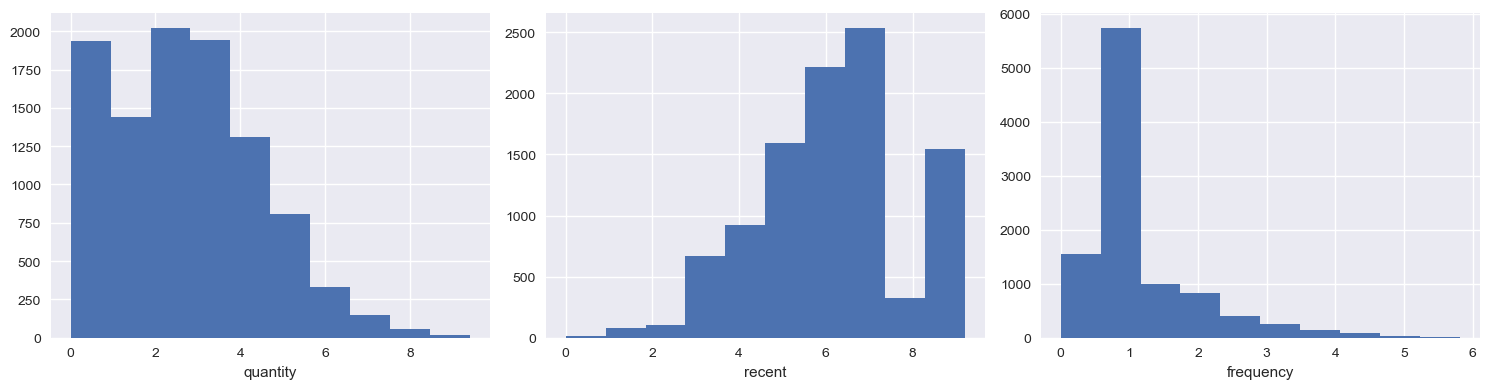

In [23]:
# drawing the histograms to check the result of Log normalization
plot_hist(df_customers, col)

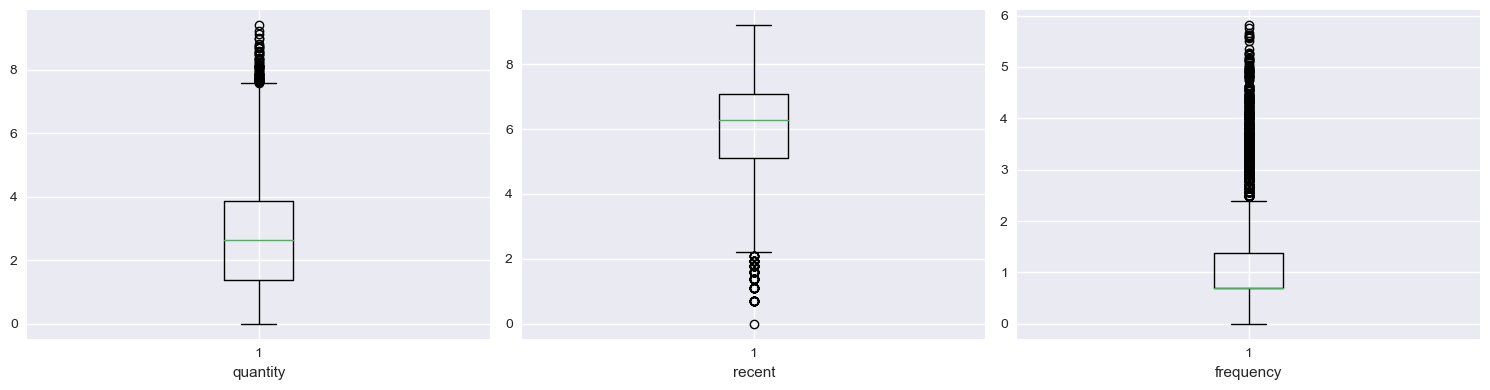

In [24]:
# drawing the barplots to check the result of Log normalization
plot_boxplot(df_customers, col)

#### Scaling

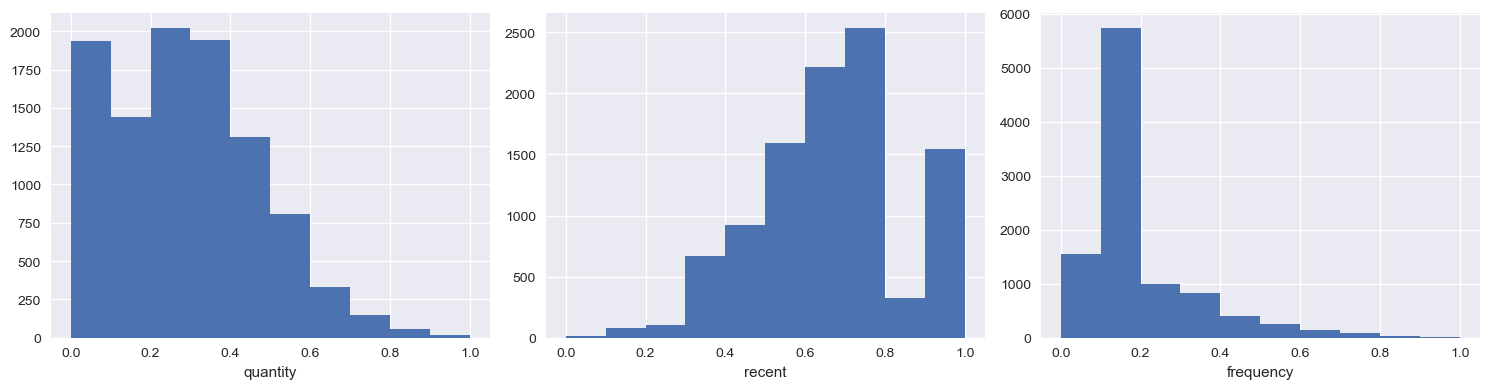

In [25]:
# scaling the numerical columns
min_max_scaler = preprocessing.MinMaxScaler()
for c in col:
    df_customers[c] = min_max_scaler.fit_transform(df_customers[c].values.reshape(-1, 1))
    
# drawing the histograms to check the result of scaling
plot_hist(df_customers, col)

#### Categorical features

As part of data exploration, I made descriptive figures of the features, so I can see the distribtions for each variable.

In [26]:
col = ['is_business', 'has_account', 'bill_state','acquisition_channel']
for i in col:
    plot_bars(df_customers, i)

### Modeling

K-means uses euclidean distance between the clustered observations and the cluster centroid. However, since our data has categorical features we cannot use K-means right off the shelf. I have two options:

1. While K-means is for categorical data and K-modes is for numerical data, there is third option that works for both data types named K-prototype.

2. When I one hot encode my categorical variables, my features will be 67. I can use PCA to both reduce my data dimension and have numerical variables only. Then I can use K-means.

I would try both of them if I had more time, but since I have never used K-prototype, and there's a time restriction. I will try my second option.

In [27]:
# one-hot encode the non-binary categorical features
df_customers = pd.get_dummies(df_customers, columns=['bill_state', 'acquisition_channel'])

In [28]:
df_customers.shape

(10000, 67)

#### PCA

In [29]:
# 0.95 says choose the number of components that keep 95% of original data's variability
pca = PCA(n_components=0.95)

In [30]:
X_pca = pca.fit_transform(df_customers.loc[:, df_customers.columns != 'customer_uid'].values)
X_pca.shape

(10000, 37)

#### K-means

Text(0, 0.5, 'SSE')

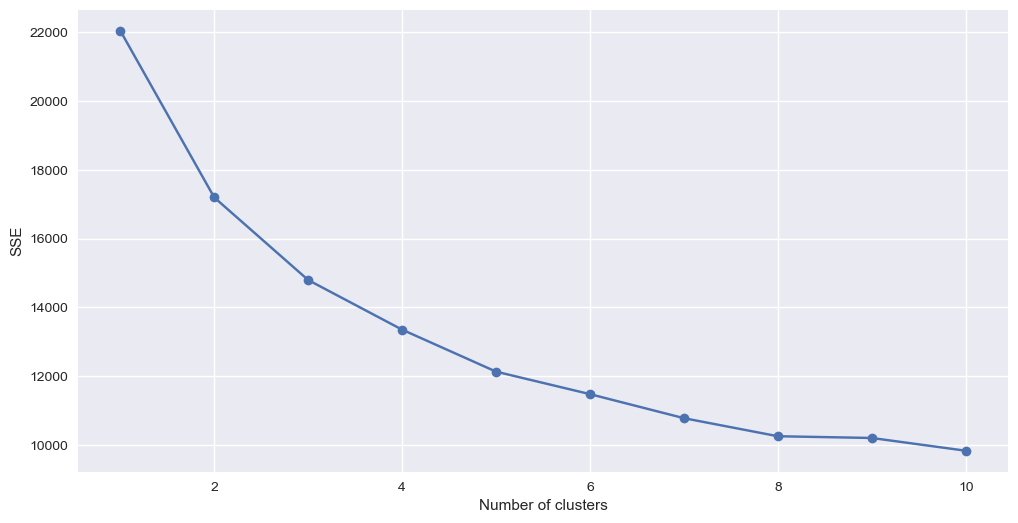

In [31]:
# choosing the k
SSE = []
k = range(1, 11)
for i in k:
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(X_pca)
    SSE.append(kmeans.inertia_)
    
df_SSE = pd.DataFrame({'K':k, 'SSE':SSE})
plt.figure(figsize=(12, 6))
plt.plot(df_SSE['K'], df_SSE['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

I think based on the graph above number of clusters 5 would be the best option, although there isn't an elbow that stands out.

In [32]:
# build a model with 5 clusters
kmeans = KMeans(n_clusters = 5, init='k-means++', random_state=0)
kmeans.fit(X_pca);

I use silhouette to evaluate the model. Silhouette is a coefficient that varies from -1 to +1. The better model has a higher silhouette.

In [33]:
silhouette_score(X_pca, kmeans.labels_)

0.27595323666581456

In [34]:
# add the labels to my original cutomers table
df_customers_original['label'] = kmeans.labels_

In [35]:
df_customers_original.head()

,customer_uid,is_business,has_account,bill_state,acquisition_channel,quantity,recent,frequency,label
0,7d30104b82c22393003ac3c07b491c15,False,False,OK,coupon aggregator,15,1822,1,4
1,77a48e4c4a69458d3421c54058350f93,False,False,CA,organic search,6,525,1,3
2,c9fe0dadc9e25ab478144bbd3a0ae750,False,False,WA,organic search,3,517,1,3
3,7a8bdb597d753c6c7430ea4e1d52fc48,False,False,TX,organic search,1,781,1,3
4,becb1413c375caba8707085efaac08e9,False,False,IL,organic search,7,1323,1,3


In [36]:
df = pd.DataFrame({'label': df_customers_original['label'].unique(), 'count': df_customers_original['label'].value_counts()})
fig = px.bar(df, x='label', y = 'count', title='label', color='label')
fig.update_xaxes(type='category')
fig.show()

### Analyze the result

How is my clusters against is_business feature:

In [37]:
x = list(df_customers_original['label'].unique())
table = pd.crosstab(index=df_customers_original['is_business'], columns=df_customers_original['label']).reset_index()

plot = px_o.Figure(data=[px_o.Bar(
    name = 'Business',
    x = x,
    y = list(table.loc[table['is_business']==True, x].values[0])
   ),
                       px_o.Bar(
    name = 'Not Business',
    x = x,
    y = list(table.loc[table['is_business']==False, x].values[0])
   )
])

fig.update_xaxes(type='category')
plot.show()

Cluster 0, 2 and 4 have no business customers. Cluster 3 has some, but most of the business customers are in cluster 1.

How is my clusters against has_account feature:

In [38]:
x = list(df_customers_original['label'].unique())
table = pd.crosstab(index=df_customers_original['has_account'], columns=df_customers_original['label']).reset_index()

plot = px_o.Figure(data=[px_o.Bar(
    name = 'With Account',
    x = x,
    y = list(table.loc[table['has_account']==True, x].values[0])
   ),
                       px_o.Bar(
    name = 'Without Account',
    x = x,
    y = list(table.loc[table['has_account']==False, x].values[0])
   )
])

fig.update_xaxes(type='category')
plot.show()

Interestingly, cluster 1 had the most business customers and most customers who have accounts. Does it mean most of my business customers make accounts? We can't tell by just looking at this graph, but maybe it is worth investigation.

Showing how the numerical variables look like within each group of customers:

In [39]:
df_customers_original.groupby('label').agg({'quantity': ['median', 'std'],
                                           'frequency': ['median', 'std'],
                                           'recent': ['median', 'std'],}).reset_index().round(2)

label quantity         frequency        recent         
          median     std    median    std median      std
0     0      5.0   38.22       1.0   2.99  323.0  4505.18
1     1     44.0  663.07       2.0  25.76  335.0  3419.82
2     2     27.0   68.51       2.0   4.18  333.0  3528.46
3     3      5.0   79.62       1.0   2.10  751.0  3594.51
4     4      6.0   11.54       1.0   0.00  862.0   402.77

Plot the median of the numerical variables against each group:

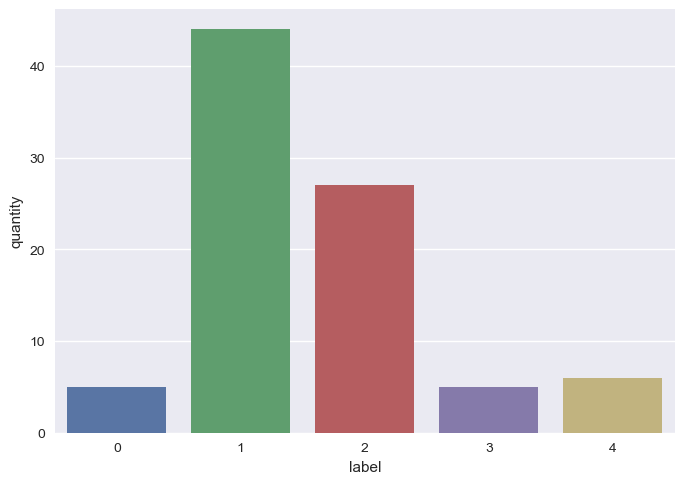

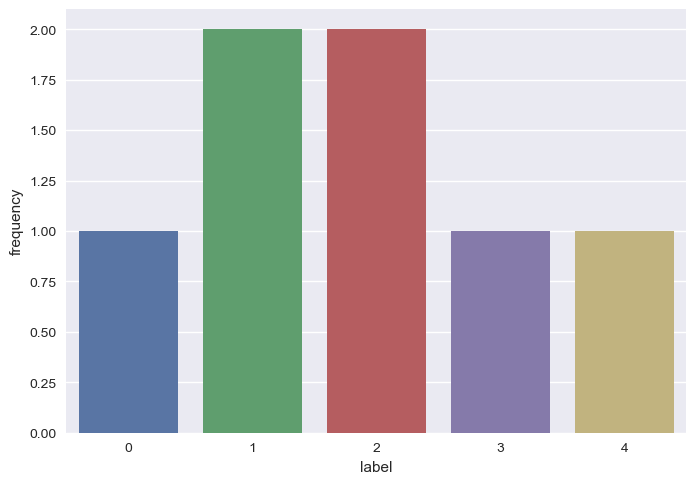

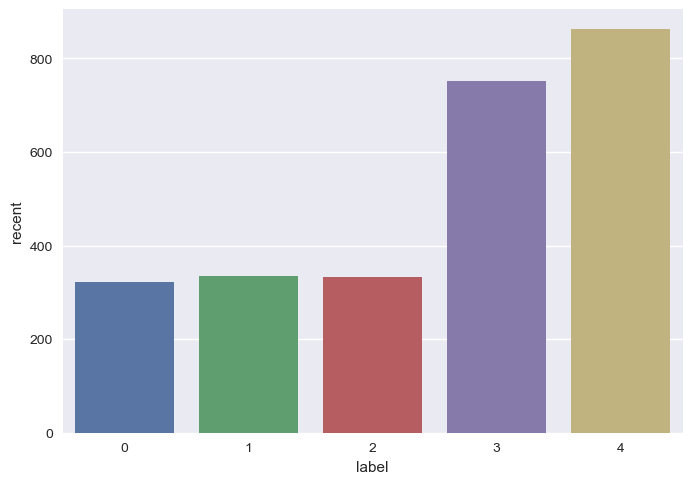

In [40]:
cols = ['quantity', 'frequency', 'recent']
df_median = df_customers_original.groupby(['label'], as_index=False).median()
for i in cols:
    sns.barplot(x='label',y=str(i),data=df_median)
    plt.show()

Group 1 that is the group with largest number of business customers shops the largest quantity and very frequently!

We can continue analyzing each group and understand each group of customers better. However, because of time constraint, I stop at this point. 

### One idea

It would be interesting to know which of the features contributed the most to the PCA. One way of going about this would be to regress each principal component against a variable, and extract the R-squared value. First, we could set up an empty matrix with each row representing a principal component and each column a variable. Then we populate each element of that matrix with the R-squared value (i.e. row 1, column 1 would be the R-squared corresponding to principal component 1 and variable 1). Since R-squared represents the proportion of variation in the PC explained by the variable and the explained variance ratio represents the amount of variation explained by the specific PC in PCA, we can multiply these together and sum them across all PCs. 

So, if X_i is the explained variance ratio of PC_i (among I PCs) and R2_ij is the R-squared value for PC_i and variable j among J variables, then the total  contribution of variable j to the PCA could be computed as X_1 * R2_1j + X_2 * R2_2j + ... + X_I * R2_Ij. This can be repeated for all variables J, such that we can compare the total contributions across variables.